In [1]:
# Install R
!apt-get install r-base
# Install IRKernel (R kernel for Jupyter)
!R -e "install.packages('IRkernel')"
!R -e "IRkernel::installspec(user = FALSE)"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.3-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.

R version 4.4.3 (2025-02-28) -- "Trophy Case"
Copyright (C) 2025 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> install.packages('IRkernel')
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspec

In [46]:
# Load necessary libraries
library(tidyverse)

# Load the datasets
train_data <- read.csv("/content/train.csv")
test_data <- read.csv("/content/test.csv")
gender_submission_data <- read.csv("/content/gender_submission.csv")

# Inspect the first few rows of each dataset
head(train_data)
head(test_data)
head(gender_submission_data)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,,Q
2,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,,S
3,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,,Q
4,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,,S
5,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,,S
6,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,,S


,PassengerId,Survived
,<int>,<int>
1,892,0
2,893,1
3,894,0
4,895,0
5,896,1
6,897,0


# Handling missing values:

In [47]:
# Impute Age with the median (for both train and test)
train_data$Age[is.na(train_data$Age)] <- median(train_data$Age, na.rm = TRUE)
test_data$Age[is.na(test_data$Age)] <- median(test_data$Age, na.rm = TRUE)

# Impute Embarked with the most frequent value (mode)
train_data$Embarked[is.na(train_data$Embarked)] <- 'S'  # Assuming 'S' is the most frequent Embarked port

# Drop non-useful columns: 'Name', 'Ticket', and 'Cabin' (but keep 'PassengerId' in test data for predictions)
train_data_clean <- train_data %>% select(-c(Name, Ticket, Cabin))
test_data_clean <- test_data %>% select(-c(Name, Ticket, Cabin))

Convert Categorical Variables to Numeric

In [48]:
# Convert 'Sex' to numeric (male = 0, female = 1)
train_data_clean$Sex <- ifelse(train_data_clean$Sex == "male", 0, 1)
test_data_clean$Sex <- ifelse(test_data_clean$Sex == "male", 0, 1)

# Convert 'Embarked' to numeric (C = 0, Q = 1, S = 2)
train_data_clean$Embarked <- as.factor(train_data_clean$Embarked)
train_data_clean$Embarked <- as.numeric(train_data_clean$Embarked)

test_data_clean$Embarked <- as.factor(test_data_clean$Embarked)
test_data_clean$Embarked <- as.numeric(test_data_clean$Embarked)

In [49]:
# Check for any remaining missing values
sum(is.na(train_data_clean))
sum(is.na(test_data_clean))

# Display cleaned data for inspection
head(train_data_clean)
head(test_data_clean)

[1] 0

[1] 1

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,1,0,3,0,22,1,0,7.2500,4
2,2,1,1,1,38,1,0,71.2833,2
3,3,1,3,1,26,0,0,7.9250,4
4,4,1,1,1,35,1,0,53.1000,4
5,5,0,3,0,35,0,0,8.0500,4
6,6,0,3,0,28,0,0,8.4583,3


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,892,3,0,34.5,0,0,7.8292,2
2,893,3,1,47.0,1,0,7.0000,3
3,894,2,0,62.0,0,0,9.6875,2
4,895,3,0,27.0,0,0,8.6625,3
5,896,3,1,22.0,1,1,12.2875,3
6,897,3,0,14.0,0,0,9.2250,3


#Exploratory Data Analysis (EDA)

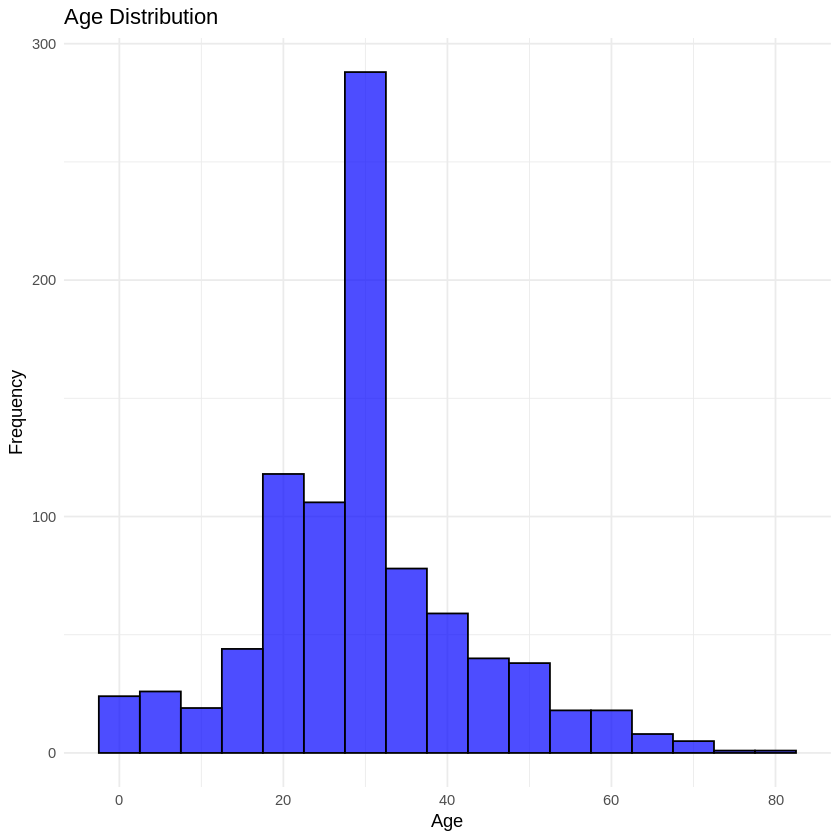

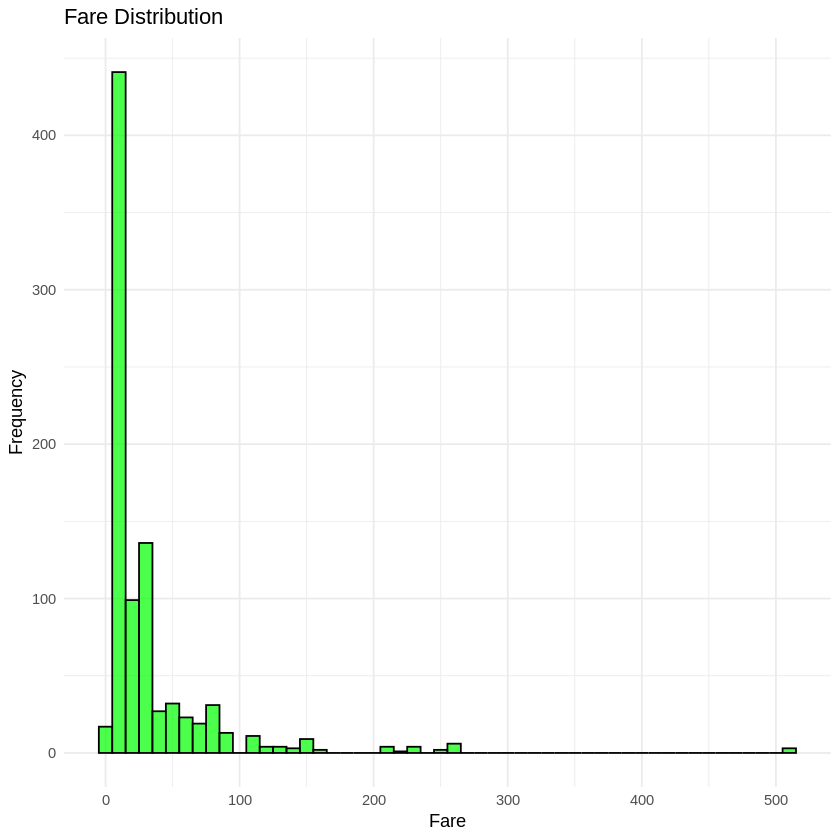

In [50]:
# Plot the distribution of Age
ggplot(train_data_clean, aes(x = Age)) +
  geom_histogram(binwidth = 5, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Age Distribution", x = "Age", y = "Frequency") +
  theme_minimal()

# Plot the distribution of Fare
ggplot(train_data_clean, aes(x = Fare)) +
  geom_histogram(binwidth = 10, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Fare Distribution", x = "Fare", y = "Frequency") +
  theme_minimal()


Visualize the Relationship Between Sex and Survival

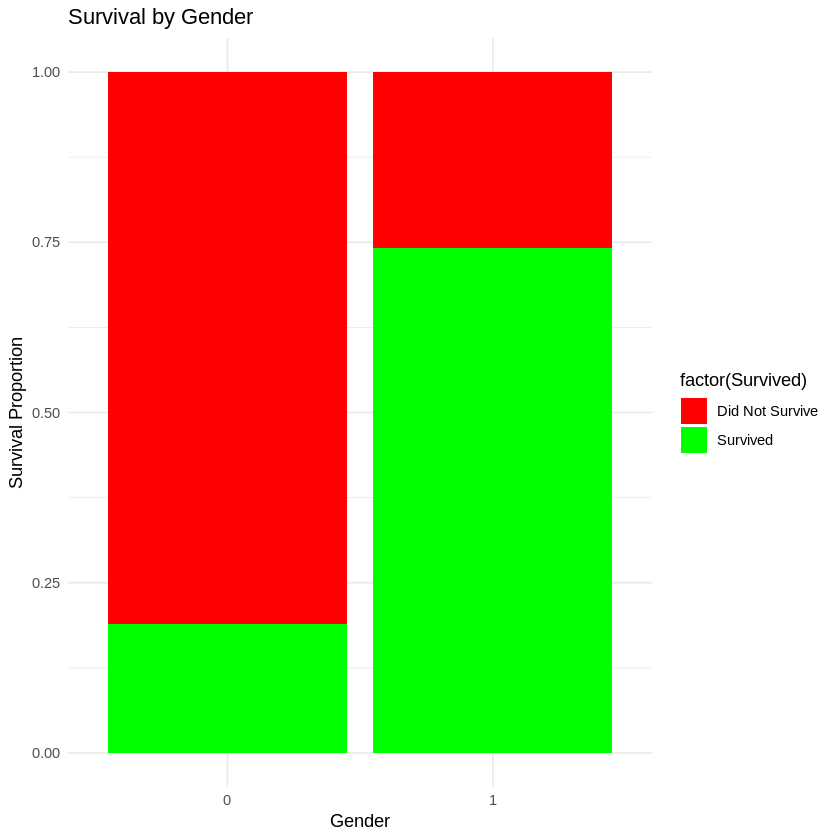

In [51]:
# Gender vs Survival (Bar plot)
ggplot(train_data_clean, aes(x = factor(Sex), fill = factor(Survived))) +
  geom_bar(position = "fill") +
  labs(title = "Survival by Gender", x = "Gender", y = "Survival Proportion") +
  scale_fill_manual(values = c("red", "green"), labels = c("Did Not Survive", "Survived")) +
  theme_minimal()


Age vs Survival (Box Plot)

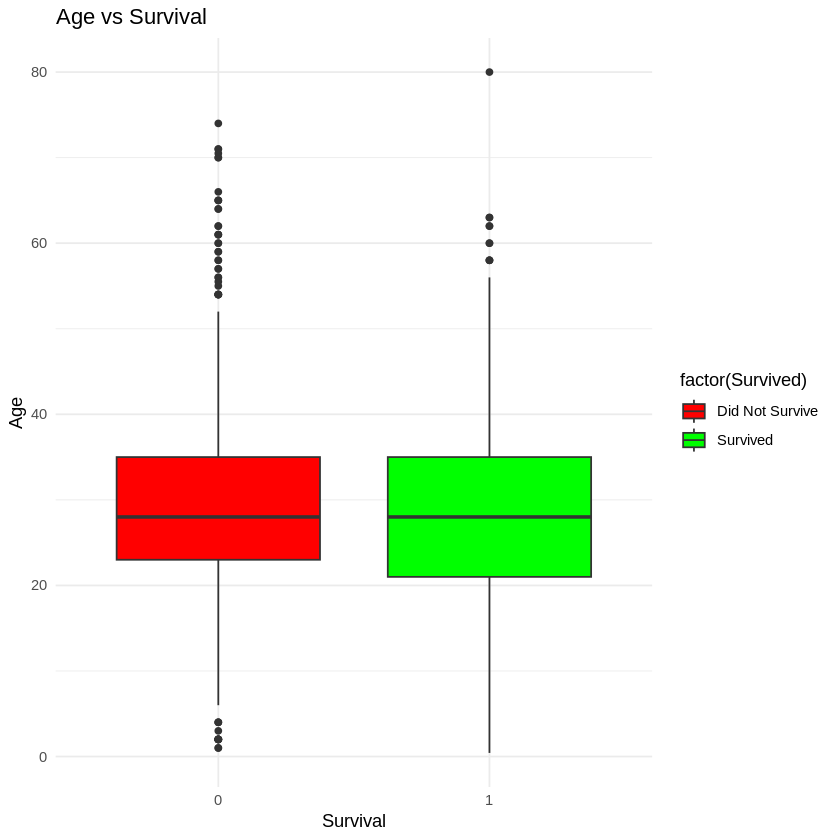

In [53]:
# Boxplot to visualize the relationship between Age and Survival
ggplot(train_data_clean, aes(x = factor(Survived), y = Age, fill = factor(Survived))) +
  geom_boxplot() +
  labs(title = "Age vs Survival", x = "Survival", y = "Age") +
  scale_fill_manual(values = c("red", "green"), labels = c("Did Not Survive", "Survived")) +
  theme_minimal()


Correlation Matrix for Numerical Features

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



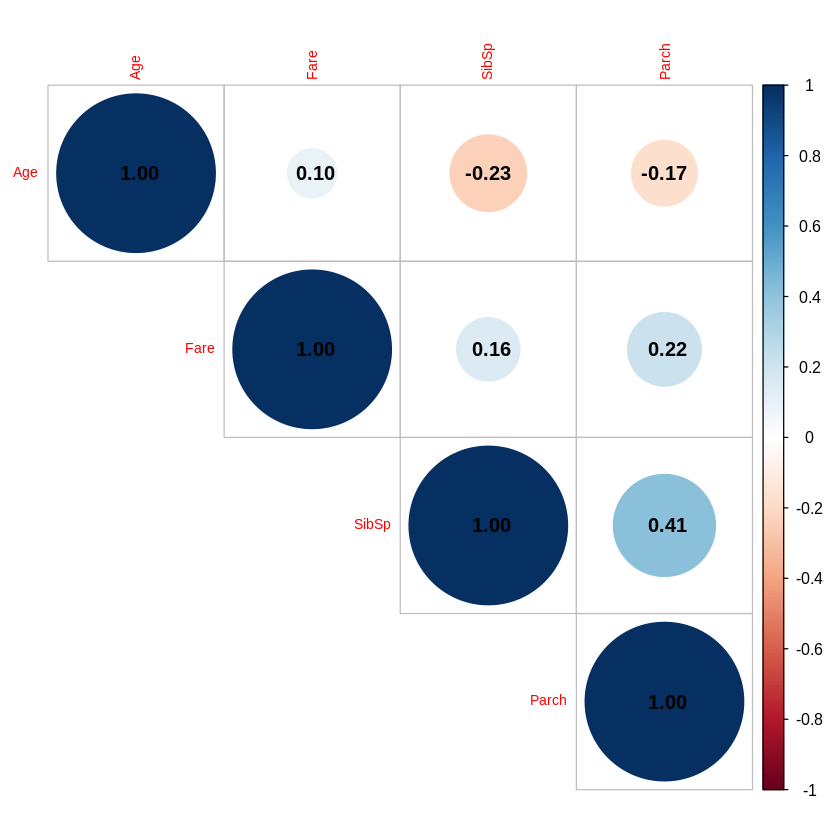

In [54]:
# Install the corrplot package
install.packages("corrplot")

# Correlation matrix to check relationships between numerical variables (Age, Fare, etc.)
cor_matrix <- cor(train_data_clean %>% select(Age, SibSp, Parch, Fare))
library(corrplot)
corrplot(cor_matrix, method = "circle", type = "upper", order = "hclust", tl.cex = 0.7, addCoef.col = "black")


#Logistic Regression Model

Prepare the Features and Target Variable:

In [55]:
# Prepare features (X) and target variable (y)
X_train <- train_data_clean %>% select(-c(Survived, PassengerId))
y_train <- train_data_clean$Survived

# Prepare the test data features (without 'PassengerId')
X_test <- test_data_clean %>% select(-c(PassengerId))


In [56]:

# Logistic Regression model
model <- glm(Survived ~ ., data = train_data_clean, family = binomial)

# Display model summary
summary(model)



Call:
glm(formula = Survived ~ ., family = binomial, data = train_data_clean)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.926e+00  6.560e-01   4.460 8.19e-06 ***
PassengerId  9.125e-05  3.488e-04   0.262  0.79360    
Pclass      -1.085e+00  1.397e-01  -7.765 8.16e-15 ***
Sex          2.739e+00  1.996e-01  13.726  < 2e-16 ***
Age         -3.904e-02  7.829e-03  -4.986 6.16e-07 ***
SibSp       -3.243e-01  1.092e-01  -2.969  0.00299 ** 
Parch       -9.735e-02  1.184e-01  -0.822  0.41085    
Fare         1.951e-03  2.388e-03   0.817  0.41413    
Embarked    -2.221e-01  1.145e-01  -1.939  0.05250 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1186.66  on 890  degrees of freedom
Residual deviance:  785.36  on 882  degrees of freedom
AIC: 803.36

Number of Fisher Scoring iterations: 5


In [63]:
# Replace this part with base R train-test split
set.seed(42)

# Create a random index to split data (80% for training, 20% for validation)
train_index <- sample(1:nrow(train_data_clean), size = 0.8 * nrow(train_data_clean))

# Split the data into training and validation sets
train_split <- train_data_clean[train_index, ]
valid_split <- train_data_clean[-train_index, ]
model_split <- glm(Survived ~ ., data = train_split, family = binomial)


In [64]:
# Make predictions on the validation set
valid_predictions <- predict(model_split, valid_split, type = "response")

# Convert probabilities to binary values (0 or 1)
valid_predictions <- ifelse(valid_predictions > 0.5, 1, 0)


In [66]:
# Calculate Precision, Recall, and F1 Score (using base R)
TP <- sum(valid_predictions == 1 & valid_split$Survived == 1)
TN <- sum(valid_predictions == 0 & valid_split$Survived == 0)
FP <- sum(valid_predictions == 1 & valid_split$Survived == 0)
FN <- sum(valid_predictions == 0 & valid_split$Survived == 1)

# Calculate Precision, Recall, and F1 Score
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)
f1_score <- 2 * (precision * recall) / (precision + recall)

# Print the metrics
cat("Precision: ", precision, "\n")
cat("Recall: ", recall, "\n")
cat("F1-Score: ", f1_score, "\n")

Precision:  0.6885246 
Recall:  0.6461538 
F1-Score:  0.6666667 
